INCOMPLETE: There is a mismatch between the implementation from the paper and package results.

This notebook implements a low frequency approximation for MEEM. The approximation uses the first radial eigenfunction(s) for each region while the vertical eigenfunction is constant (no z-dependence). It is "depth-averaged", and every A-matrix/b-vector equation is divided by the integrated depth. The general form is shown to match the two-region form given in Chau 2012. Damping converges to a finite value while added mass goes to infinite.

Previous results, now suspect: Comparisons between the outputs generated in this file and via the full MEEM implementations show that the convergence between the approximation and the full version is very slow, and configuration dependent. The conclusion is that this should not be added to the final package.

In [1]:
#import block
import numpy as np
import pickle
from scipy.special import hankel1 as besselh
import scipy.linalg as linalg
from numpy import log, pi, sqrt
import matplotlib.pyplot as plt
from openflash import *

import sys
from pathlib import Path
HERE = Path.cwd().resolve()
cpt_dir = (HERE / ".." / ".." / ".." / "analysis").resolve()
if str(cpt_dir) not in sys.path:
    sys.path.insert(0, str(cpt_dir))

from capytaine_generator import CapytaineSlantSolver
import capytaine as cpt
from low_m0 import low_get_nondim_hydros, low_to_nondim, low_get_max_heaving_radius

In [2]:
# constants block
g = 9.81
rho = 1023

In [3]:
# Computing with package MEEM
def make_flat_geometry(h, d, a, heaving, NMK):
  if sum(heaving) == len(heaving):
    bodies = [SteppedBody(a=np.array(a), d=np.array(d), slant_angle=np.array([0.0 for _ in range(len(a))]), heaving=True)]
  else:
    bodies = [SteppedBody(a=np.array([a[i]]), d=np.array([d[i]]), slant_angle=np.array([0.0]), heaving=heaving[i]) for i in range(len(a))]
  return BasicRegionGeometry(body_arrangement=ConcentricBodyGroup(bodies), h=h, NMK=NMK)

def make_problem_and_engine(h, d, a, heaving, m0s, NMK):
  frequencies = np.array([omega(m0, h, g) for m0 in m0s])
  problem = MEEMProblem(make_flat_geometry(h, d, a, heaving, NMK))
  problem.set_frequencies(frequencies)
  engine = MEEMEngine(problem_list=[problem])
  return problem, engine

def solve_true_MEEM(h, d, a, heaving, m0s, NMK):
  problem, engine = make_problem_and_engine(h, d, a, heaving, m0s, NMK)
  nondim_ams, nondim_dps = [], []
  if sum(heaving) == len(heaving):
    modes_to_calculate = [0]
  else:
    modes_to_calculate = np.array([i for i in range(len(heaving)) if heaving[i]])
  for m0 in m0s:
    X = engine.solve_linear_system_multi(problem, m0)
    hydros = engine.compute_hydrodynamic_coefficients(problem, X, m0, modes_to_calculate=modes_to_calculate)
    nondim_ams.append(low_to_nondim(hydros[0]["real"], low_get_max_heaving_radius(a, heaving)))
    nondim_dps.append(low_to_nondim(hydros[0]["imag"] / omega(m0, h, g), low_get_max_heaving_radius(a, heaving)))
  return nondim_ams, nondim_dps

In [4]:
# Computing with Capytaine
css = CapytaineSlantSolver(False, False, False, False, False)
def compute_cpt_slant(config, t_densities):
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 50, config["h"], config["omega"], config["rho"], 1)
  am, dp, f_ex = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"], (cpt.assemble_dataset([respack[2]]))["excitation_force"][0][0][0].values
  return am, dp, f_ex

def BEM_hydro_coeffs(h, rho, omega_sweep, d_in, d_out, a_list, heaving_list):
    # Run BEM
    t_densities = [30, 50]
    A_BEM = np.zeros_like(omega_sweep)
    B_BEM = np.zeros_like(omega_sweep)
    F_ex_BEM = np.zeros(len(omega_sweep), dtype=np.complex128)

    for j in range(len(omega_sweep)):
        i=1
        omega = omega_sweep[j]
        config = {"name" : "config-(" + str(i) + ")",
                    "h" : h,
                    "a" : a_list,
                    "d_in" : d_in,
                    "d_out" : d_out,
                    "heaving": heaving_list,
                    "NMK" : [100, 100], #this is unused
                    "omega" : omega,
                    "rho" : rho}
        Capy_results = compute_cpt_slant(config, t_densities)
        A_BEM[j] = Capy_results[0]
        B_BEM[j] = Capy_results[1]
        F_ex_BEM[j] = Capy_results[2]
        print(j)
    return A_BEM, B_BEM, F_ex_BEM

In [5]:
# 2012 solutions for low frequency (2 cylinder, directly)
# Heaving outer cylinder
def oc_heaving(h, a1, a2, d1, d2, m0):
    term_1 = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + ((a2**2 - a1**2)/4 + (a1**2/2) * log(a1/a2))/(h-d2)
    beta = term_1 + ((a2**2)/4 - (a1**2/2) * log(a2))/(h-d2)
    gamma = a1**2/(2 * (h-d2))
    delta = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2)/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def oc_heaving_hydros(h, a1, a2, d1, d2, m0):
    t1 = (a2**2 - a1**2)**2/(2 * h * m0 * a2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    t2 = ((a2**2 - a1**2)**2 + 2 * a1**2 * (a1**2 - a2**2 + 2 * a1**2 * log(a2/a1)))/(8 * (h - d2))
    val = (t1 + t2)/(a2 ** 3)
    # print(t1/a2**3)
    # print(t2/a2**3)
    return np.real(val), np.imag(val)

# Heaving inner cylinder
def ic_heaving(h, a1, a2, d1, d2, m0):
    term_1 = (a1**2/(2 * m0 * h * a2)) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + (a1**2 * log(a2/a1))/(2 * (h-d2)) + a1**2/(4 * (h-d1))
    beta = term_1 + (a1**2 * log(a2))/(2 * (h-d2))
    gamma = -a1**2/(2 * (h-d2))
    delta = (a1**2/(2 * m0 * h * a2))/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def ic_heaving_hydros(h, a1, a2, d1, d2, m0):
    t1 = (besselh(0, m0 * a2))/(h * m0 * a2 * besselh(1, m0 * a2))
    t2 = log(a2/a1)/(h-d2) + 1/(4*(h-d1)) # It's an error that (eq. 84) has an 8 instead of a 4 here.*
    val = (a1/2) * (t1 + t2)
    return np.real(val), np.imag(val)
    # *If the integral in eq. 84 is correct, it evaluates to having a 4 instead of an 8 there.

# the paper claims these as the limits (m0 -> 0) but I'm not sure  
def oc_heaving_lim_am(h, a, m0s):
    return -a[1]/(2*h)*(1 - (a[0]/a[1])**2)**2 * log(m0s * a[1])

def oc_heaving_lim_dp(h, a, m0s):
    return len(m0s) * [pi * a[1] / (4 * h) * (1 - (a[0]/a[1])**2)**2]

def ic_heaving_lim_am(h, a, m0s):
    return - a[0]/(2*h) * log(m0s * a[1])

def ic_heaving_lim_dp(h, a, m0s):
    return len(m0s) * [pi * a[0] / (4 * h)]

In [6]:
# variables

h = 50
d = [14.45, 14.45-7.32-5.08]
a = [2.5/2, 8.4/2]
# heaving_list = True 
# h = 70
# d = [35, 3]
# a = [3, 10]
m0s = np.array(list(range(1, 101, 1))) * 1e-6
omega_sweep = [sqrt(m0 * np.tanh(m0 * h) * g) for m0 in m0s]
a1, a2, d1, d2 = a[0], a[1], d[0], d[1]

In [7]:
# Get Capytaine values
file1 = 'low-m0-capytaine.pkl'
# # cpt_am_ic, cpt_dp_ic, _ = BEM_hydro_coeffs(h, rho, omega_sweep, d, d, a, [1, 0])
# # cpt_am_oc, cpt_dp_oc, _ = BEM_hydro_coeffs(h, rho, omega_sweep, d, d, a, [0, 1])
# cpt_data = {"Added Mass, IC" : cpt_am_ic,
#             "Damping, IC" : cpt_dp_ic,
#             "Added Mass, OC" : cpt_am_oc,
#             "Damping, OC" : cpt_dp_oc}

# with open(file1, 'wb') as file:
#     pickle.dump(cpt_data, file)

with open(file1, 'rb') as file:
    cpt_data = pickle.load(file)

cpt_am_ic = cpt_data["Added Mass, IC"]
cpt_dp_ic = cpt_data["Damping, IC"]
cpt_am_oc = cpt_data["Added Mass, OC"]
cpt_dp_oc = cpt_data["Damping, OC"]

cpt_am_ic_nd = [low_to_nondim(coeff, a[0]) for coeff in cpt_am_ic]
cpt_dp_ic_nd = [low_to_nondim(cpt_dp_ic[i] / omega_sweep[i], a[0]) for i in range(len(cpt_dp_ic))]
cpt_am_oc_nd = [low_to_nondim(coeff, a[1]) for coeff in cpt_am_oc]
cpt_dp_oc_nd = [low_to_nondim(cpt_dp_oc[i] / omega_sweep[i], a[1]) for i in range(len(cpt_dp_oc))]

In [8]:
# Main computing block
true_nondim_am_ic, true_nondim_dp_ic = solve_true_MEEM(h, d, a, [1, 0], m0s, [150, 150, 150])
true_nondim_am_oc, true_nondim_dp_oc = solve_true_MEEM(h, d, a, [0, 1], m0s, [150, 150, 150])
low_nondim_am_ic, low_nondim_dp_ic = solve_true_MEEM(h, d, a, [1, 0], m0s, [1, 1, 1])
low_nondim_am_oc, low_nondim_dp_oc = solve_true_MEEM(h, d, a, [0, 1], m0s, [1, 1, 1])
nondim_am_ic, nondim_dp_ic = low_get_nondim_hydros(h, d, a, [1, 0], m0s)
nondim_am_oc, nondim_dp_oc = low_get_nondim_hydros(h, d, a, [0, 1], m0s)

# oc_coeffs = []
# ic_coeffs = []

nondim_am_ic_paper = []
nondim_dp_ic_paper = []
nondim_am_oc_paper = []
nondim_dp_oc_paper = []

for m0 in m0s:
    nd_oc_am, nd_oc_dp = oc_heaving_hydros(h, a1, a2, d1, d2, m0)
    nondim_am_oc_paper.append(nd_oc_am)
    nondim_dp_oc_paper.append(nd_oc_dp)
    nd_ic_am, nd_ic_dp = ic_heaving_hydros(h, a1, a2, d1, d2, m0)
    nondim_am_ic_paper.append(nd_ic_am)
    nondim_dp_ic_paper.append(nd_ic_dp)
    # oc_coeffs.append(oc_heaving(m0))
    # ic_coeffs.append(ic_heaving(m0))

/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.1159e-17): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.41125e-17): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.60022e-17): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.74243e-17): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:306: LinAlgWarning: Ill-conditioned matrix (rcond=5.85775e-17): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLA

In [9]:
def plot_compare(xs, ys, labs, colors, linestyles, ylab, title = None, ratio = False, low_dex = 0):
    # if ratio:
    #     ys = [ys[i][j]/ys[0][j] for i in range(len(ys)) for j in range(len(ys[0]))]
    for i in range(len(ys)):
        plt.plot(xs[low_dex:], ys[i][low_dex:], color = colors[i], linestyle = linestyles[i], label = labs[i])
    plt.legend()
    plt.xlabel("m0")
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

def coeff_comparisons(lst1, lst2, m0s):
    for i in range(len(m0s)):
        print(m0s[i])
        print(lst1[i])
        print(lst2[i])

# coeff_comparisons(ic_coeffs, solutions, m0s)

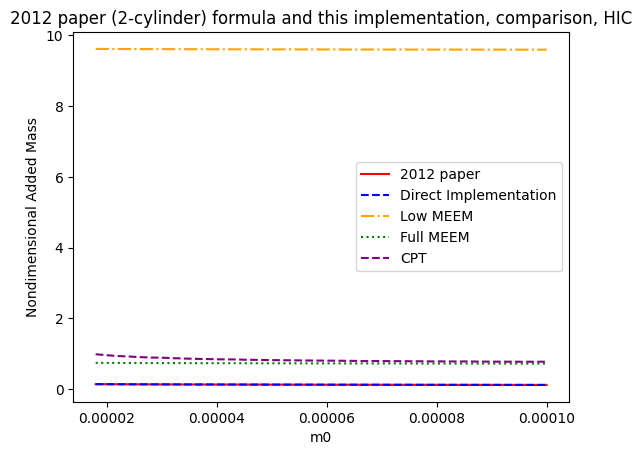

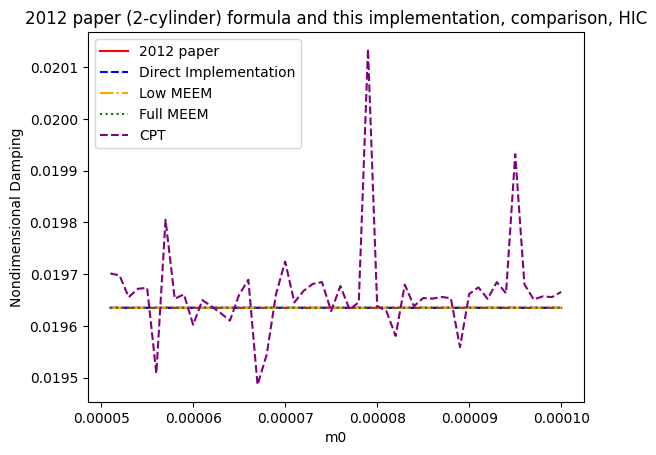

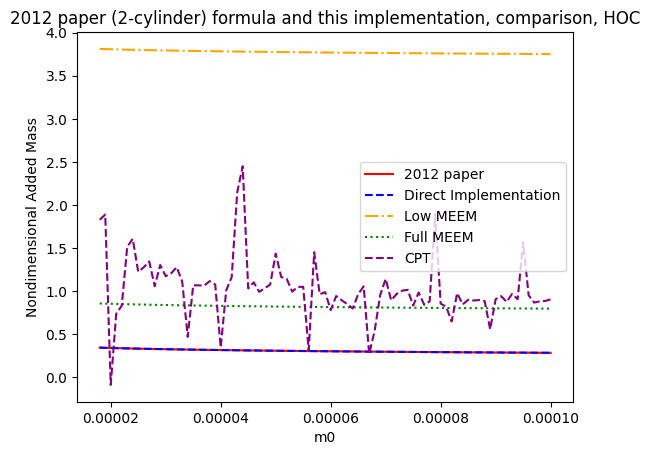

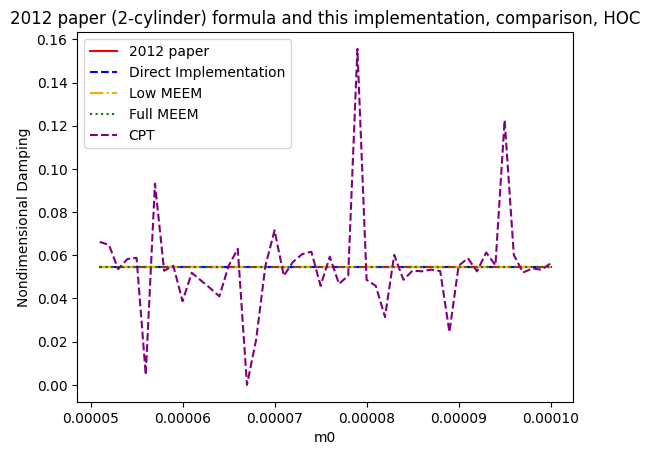

In [10]:
linestyles = ["-", "--", "-.", ":", "--"]
colors = ["red", "blue", "orange", "green", "purple"]
labs = ["2012 paper", "Direct Implementation", "Low MEEM", "Full MEEM", "CPT"]

ys1 = [nondim_am_ic_paper, nondim_am_ic, low_nondim_am_ic, true_nondim_am_ic, cpt_am_ic_nd]
ys2 = [nondim_dp_ic_paper, nondim_dp_ic, low_nondim_dp_ic, true_nondim_dp_ic, cpt_dp_ic_nd]
ys3 = [nondim_am_oc_paper, nondim_am_oc, low_nondim_am_oc, true_nondim_am_oc, cpt_am_oc_nd]
ys4 = [nondim_dp_oc_paper, nondim_dp_oc, low_nondim_dp_oc, true_nondim_dp_oc, cpt_dp_oc_nd]

plot_compare(m0s, ys1, labs, colors, linestyles, "Nondimensional Added Mass",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HIC", low_dex = 17)

plot_compare(m0s, ys2, labs, colors, linestyles, "Nondimensional Damping",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HIC", low_dex = 50)

plot_compare(m0s, ys3, labs, colors, linestyles, "Nondimensional Added Mass",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HOC", low_dex = 17)

plot_compare(m0s, ys4, labs, colors, linestyles, "Nondimensional Damping",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HOC", low_dex = 50)


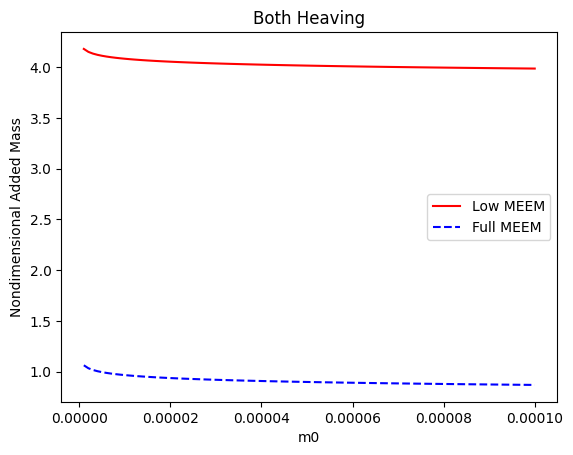

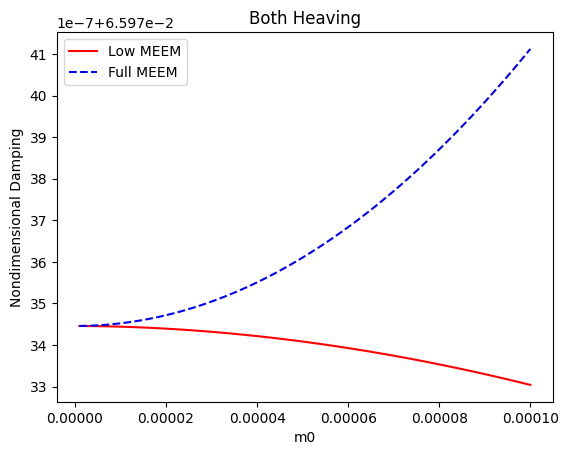

In [11]:
true_nondim_am_both, true_nondim_dp_both = solve_true_MEEM(h, d, a, [1, 1], m0s, [100, 100, 100])
low_nondim_am_both, low_nondim_dp_both = solve_true_MEEM(h, d, a, [1, 1], m0s, [1, 1, 1])
ys5 = [low_nondim_am_both, true_nondim_am_both]
ys6 = [low_nondim_dp_both, true_nondim_dp_both]
plot_compare(m0s, ys5, labs[2:], colors, linestyles, "Nondimensional Added Mass",
             title = "Both Heaving")
plot_compare(m0s, ys6, labs[2:], colors, linestyles, "Nondimensional Damping",
             title = "Both Heaving")
